In [2]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, DataCollatorForSeq2Seq, TrainingArguments, Trainer, pipeline
from datasets import DatasetDict, Dataset

import json

import matplotlib.pyplot as plt

# Importing the dataset

In [15]:
with open('data/data_train.json', 'r') as f :
    data_train = json.load(f)

with open('data/data_val.json', 'r') as f :
    data_val = json.load(f)

with open('data/data_test.json', 'r') as f :
    data_test = json.load(f)

In [16]:
def generate_dataset_from_json(data) :
    text = []
    summary = []
    uid = []
    for key in data.keys() :
        item = data[key]
        text.append(item['original_text'])
        summary.append(item['reference_summary'])
        uid.append(item['uid'])
    res_ds = Dataset.from_dict({"text": text, "summary": summary})
    return(res_ds)

In [17]:
ds_train = generate_dataset_from_json(data_train)
ds_val = generate_dataset_from_json(data_val)

In [18]:
ds_train

Dataset({
    features: ['text', 'summary'],
    num_rows: 378
})

In [19]:
ds_val

Dataset({
    features: ['text', 'summary'],
    num_rows: 20
})

In [20]:
ds_training = DatasetDict({'train' : ds_train, 'val' : ds_val})

In [21]:
ds_training

DatasetDict({
    train: Dataset({
        features: ['text', 'summary'],
        num_rows: 378
    })
    val: Dataset({
        features: ['text', 'summary'],
        num_rows: 20
    })
})

# Setup of the training

In [22]:
model = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSeq2SeqLM.from_pretrained(model).to('cuda')

276 133


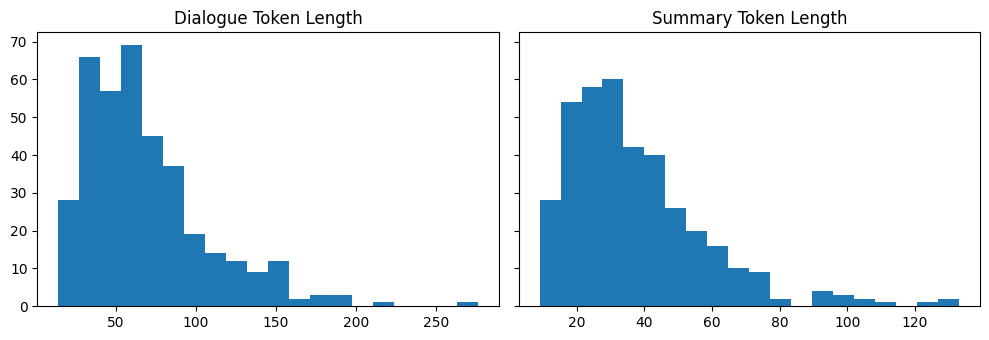

In [23]:
d_len = [len(tokenizer.encode(s)) for s in ds_training["train"]["text"]]
s_len = [len(tokenizer.encode(s)) for s in ds_training["train"]["summary"]]

print(max(d_len), max(s_len))

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20)
axes[0].set_title("Dialogue Token Length")
axes[1].hist(s_len, bins=20)
axes[1].set_title("Summary Token Length")
plt.tight_layout()
plt.show()

In [24]:
tokenizer.as_target_tokenizer()

In [25]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["text"], max_length=512, truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=256, truncation=True)
        
    return {
        "input_ids": input_encodings["input_ids"], 
        "attention_mask": input_encodings["attention_mask"],  
        "labels": target_encodings["input_ids"]
    }

In [26]:
ds_training_pt = ds_training.map(convert_examples_to_features)
columns = ["input_ids", "labels", "attention_mask"]
ds_training_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/378 [00:00<?, ? examples/s]

/home/nicehacker/anaconda3/envs/hack-env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [27]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [28]:
training_args = TrainingArguments( output_dir="training_bart",
                                 num_train_epochs=30,
                                #  warmup_steps=500,
                                 per_device_train_batch_size=1,
                                 per_gpu_eval_batch_size=1,
                                 weight_decay=0.01,
                                 logging_steps=10,
                                 report_to="none")

In [29]:
trainer = Trainer(model=model, 
                 args=training_args,
                 tokenizer=tokenizer,
                 data_collator=seq2seq_data_collator,
                 train_dataset=ds_training_pt["train"],
                 eval_dataset=ds_training_pt["val"])

In [30]:
trainer.train()

Step,Training Loss
10,1.426900
20,1.449900
30,1.610200
40,1.414900
50,1.281900
60,1.426400
70,1.729400
80,1.428600
90,1.242100
100,1.586600


Checkpoint destination directory training_bart/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Checkpoint destination directory training_bart/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decodi

KeyboardInterrupt: 

In [18]:
trainer.save_model('training_bart/model2/')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [3]:
summarizer = pipeline(task="summarization", model='/home/nicehacker/training_bart/model2')

In [20]:
generated_sum_dict = {}
for key in data_test.keys() :
    item = data_test[key]
    text = item['original_text']
    uid = item['uid']
    sum_generated = summarizer(text)[0]['summary_text']
    generated_sum_dict[key] = {'generated_summary' : sum_generated, 'uid' : uid}

Your max_length is set to 142, but your input_length is only 60. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=30)
Your max_length is set to 142, but your input_length is only 39. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 142, but your input_length is only 103. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=51)
Your max_length is set to 142, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)
You

In [21]:
with open('data/generated_summary.json', 'w', encoding='utf-8') as f:
    json.dump(generated_sum_dict, f, ensure_ascii=False, indent=4)

In [4]:
with open('data/test_set_for_eval.json', 'r') as f :
    data_test_eval = json.load(f)

In [5]:
generated_sum_for_eval_dict = {}
for key in data_test_eval.keys() :
    item = data_test_eval[key]
    text = item['original_text']
    uid = item['uid']
    sum_generated = summarizer(text)[0]['summary_text']
    generated_sum_for_eval_dict[key] = {'generated_summary' : sum_generated, 'uid' : uid}

Your max_length is set to 142, but your input_length is only 76. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=38)


Your max_length is set to 142, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Your max_length is set to 142, but your input_length is only 70. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=35)
Your max_length is set to 142, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Your max_length is set to 142, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
You

In [6]:
with open('data/generated_summary_for_eval.json', 'w', encoding='utf-8') as f:
    json.dump(generated_sum_for_eval_dict, f, ensure_ascii=False, indent=4)